In [1]:
# Initial notebook setup -- RUN ME FIRST!
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 14})
rcParams['figure.figsize'] = (10, 5)

# Fourier analysis of LIGO data

In this notebook, we will look at data from the LIGO Hanford and Livingston interferometers, taken during the GW150914 event. This was the first detection of gravitational waves by LIGO and it was due to a binary black hole merger. A reconstruction of the waveform is shown here.

<img src="https://losc.ligo.org/s/events/GW150914/P150914/fig2-waveform.png" style="width: 50%;" />

We can download the timestream data for this event from the [LIGO Open Science Center](https://losc.ligo.org). Run the cell below to get 10 seconds of data, centered on GW150914, from both Hanford and Livingston. 

This notebook relies heavily on the [quickview.ipynb](https://losc.ligo.org/tutorials/) notebook provided on the LIGO OSC. Compared to our previous data analysis exercises, this one relies heavily on some of the functions from the numpy, scipy, and matplotlib modules. When I introduce new function below, I tried to link to online documentation. But you can always use the python help function if you need more information.


In [2]:
# Download data from LIGO Open Science Center.
# These are actually unix shell commands. We can run them from inside the Jupyter notebook by 
# putting an exclamation point '!' at the start of the line.





The LIGO data that we just downloaded are stored in simple text files that list the measured strain for each time sample. You can look at them here: [Hanford](H-H1_LOSC_4_V2-1226259446-32.txt), [Livingston](L-L1_LOSC_4_V2-1126259446-32.txt). 

Remember the lecture discussion of how LIGO operates. For each sample, LIGO records an estimate of the fractional difference in length between its 4 km arms. The values are very small! Strains of ~$10^{-19}$ mean that the arms differ in length by $4 \times 10^{-14}$ cm! Of course, this record of the strains is dominated by noise. Our challenge today will be to dig through the noise to find a gravitational wave signal.

For these files, LIGO is sampled at 4096 Hz. Run the next cell to read the files, print a few details, and define an array of time values that corresponds to the samples. Note that we use the `np.arange` function to define the time array.

In [3]:
# Read data from Hanford and Livingston observatories.
Han = np.genfromtxt('H-H1_LOSC_4_V2-1126259446-32.txt')
Liv = np.genfromtxt('L-L1_LOSC_4_V2-1126259446-32.txt')
N = len(Han)
N1 = len(Liv)
print("Number of data samples = {}".format(N1))

# Sample rate is 4096 Hz.
sample_rate = 4096.0
print("Sample rate = {} Hz".format(sample_rate))
# Use this to calculate total duration and time step between samples.
duration = N / sample_rate
duration1 = N1 / sample_rate
print("Observation duration = {} seconds".format(duration1))
dt = 1.0 / sample_rate
print("Delta-t = {:0.6f} seconds".format(dt))

# Create an array of time values, centered at zero.
time = np.arange(0, duration, dt) - duration / 2.0
time1 = np.arange(0, duration1, dt) - duration1 / 2.0

Number of data samples = 131072
Sample rate = 4096.0 Hz
Observation duration = 32.0 seconds
Delta-t = 0.000244 seconds


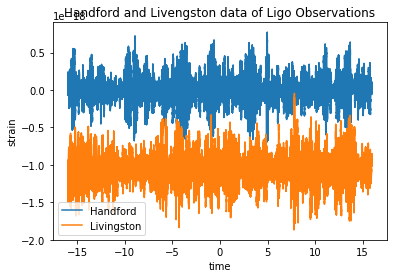

In [4]:
# Now, plot data as a function of time for both Hanford and Livingston (use the plt.plot function)
# Can you see any gravitational wave signal?
# Compare the range on the y-axis to the strain values from the figure at the top of this notebook.

plt.plot(time,Han)
plt.plot(time1,Liv)
plt.title('Handford and Livengston data of Ligo Observations')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend(('Handford','Livingston'))

The noise in the interferometers is clearly much larger than the signal we are after. Fortunately, we know that gravitational waves from the black hole merger will have particular frequencies, starting low and then quickly ramping up to ~300 Hz. LIGO is most sensitive from about 50 to 500 Hz, so we can focus our search there and filter out other noise.

The Fourier transform is a tool that allows us to take time-ordered data and express it as the sum of waves at many frequencies. 
* The lowest frequency we can measure is (1 / duration), *i.e.* the wave that completes just one period during our observation.
* The highest frequency we can measure is known as the Nyquist frequency, which is equal to one half the sampling rate. What would happen if you tried to measure a wave with frequency *equal* to the sampling rate?
* For each frequency, the Fourier transform gives you a complex number, *i.e.* real part and imaginary part. This is equivalent providing the amplitude, $\sqrt{\mathrm{Re}^2 + \mathrm{Im}^2}$, and phase, $\arctan(\mathrm{Im} / \mathrm{Re})$, of the wave.

Run the cell below to load some modules and functions that we will use for Fourier analysis. 


In [5]:
# Load some modules that we will use for Fourier analysis.
from numpy.fft import rfft, irfft, rfftfreq
from scipy.signal import butter, filtfilt
import matplotlib.mlab as mlab


The first function we will use is [`rfft`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.rfft.html), which calculates the Fourier transform of real-valued (not complex) input data. 

There is a helper function, [`rfftfreq`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.rfftfreq.html#numpy.fft.rfftfreq), that computes the frequency values corresponding to each point in your Fourier transform. To use `rfftfreq`, give two arguments: the number of samples in the time-ordered data (defined above as `N`) and the time step between samples (defined above as `dt`).

Because the Fourier transform values are complex, they can be difficult to visualize. Instead, we usually plot the *power spectrum*, which is the square of the absolute value of the Fourier transform, *i.e.* `np.abs(FT)**2` if `FT` is your Fourier transform. This tells you about the amplitude of the waves at each frequency, but discards any information about their phases. The power spectrum is strictly positive (because it is the square of an absolute value) and it often spans many orders of magnitude. For these reasons, it is usually helpful to plot it on logarithmic axes, using [`plt.loglog`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.loglog.html).


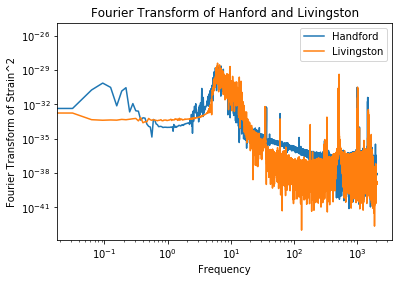

In [6]:
# Use rfft and rfftfreq to calculate the Fourier transform of the Hanford or Livingston data.

fourierhan = rfft(Han)
fourierliv = rfft(Liv)
freq = rfftfreq(N,dt)
freq1 = rfftfreq(N1,dt)



# Plot abs(fft)**2 as a function of frequency on a logarithmic plot (use plt.loglog instead of plt.plot).

plt.loglog(freq,np.abs(fourierhan)**2)
plt.loglog(freq1,np.abs(fourierliv)**2)
plt.title('Fourier Transform of Hanford and Livingston')
plt.xlabel('Frequency')
plt.ylabel('Fourier Transform of Strain^2')
plt.legend(('Handford','Livingston'))



From the power spectrum plots, we can see that LIGO noise amplitude is much higher at some frequencies than others. To deal with this, we are going to "whiten" the data. White noise is noise that has the same amplitude at all frequencies, so we can whiten data by taking the Fourier transform, dividing by the square root of the power spectrum, and then taking the inverse Fourier transform to recover the time-ordered data. 

However, the power spectra that we calculated above are not very precise, which we can see from their noise appearance. To whiten the data, we want a smoothed version of the power spectrum. A good way to get this is by doing the following:
1. Divide the time-ordered data into a many separate slices.
2. Calculate the power spectrum of each slice.
3. Average these power spectra together to get a smoothed power spectrum. Note that this method assumes that the noise properties are stationary, *i.e.* they don't change from one slice to the next.

An important thing to note is that, since we are chopping up our data into shorter slices, the lowest measurable frequency for each of these slices is not as low as the lowest measurable frequency for our full data. Similarly, the resolution of the power spectrum that we calculate this was is lower than the resolution of the power spectrum calculated from the full data, *i.e.* we measure the amplitude of waves at a smaller set of frequencies. Later on we will deal with this by interpolating off our smoothed power spectrum.

In the code block below, we calculate the power spectrum using the [`mlab.psd`](https://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd) function. We divide up the timestream into 32 slices, though you can adjust this by changing the `Ndiv` variable. For improved performance, this function is actually using *overlapping* slices and windowing the time-ordered data (Blackman window).


Text(0, 0.5, 'strain^2')

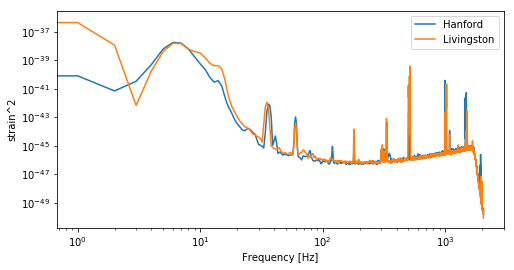

In [7]:
# This variable controls how many pieces we slice our data into.
Ndiv = 32.0

# This block of code calculates the power spectrum density by Welch's average method.
Nfft = int(N / Ndiv)
Nfft1 = int(N1 / Ndiv)
Nover = Nfft / 2.0
Nover1 = Nfft1 / 2.0
window = np.blackman(Nfft)
window1 = np.blackman(Nfft1)
Fs = sample_rate
(PHan, freqs) = mlab.psd(Han, NFFT=Nfft, noverlap=Nover, window=window, Fs=Fs)
(PLiv, freqs1) = mlab.psd(Liv, NFFT=Nfft1, noverlap=Nover1, window=window1, Fs=Fs)

# This block of code plots the results.
plt.figure(figsize=(8, 4))
plt.loglog(freqs, PHan, label='Hanford')
plt.loglog(freqs1, PLiv, label='Livingston')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('strain^2')


Now, write your own code below to whiten the time-ordered data. Remember, the steps are:
1. Take the Fourier transform of the original time-ordered data.
2. Divide the Fourier transform by the square root (`np.sqrt`) of the smoothed power spectrum that we just calculated above.
3. Use the inverse Fourier transform to convert back to time-ordered data.

Here are a few tips:
* In the code block above, we saved the smoothed power spectra as variables `PHan` and `PLiv`, for Hanford and Livingston respectively. The frequency values corresponding to those power spectra are saved as variable `freqs`.
* The smoothed power spectrum has lower resolution than the Fourier transform of the full time-ordered data. However, you can interpolate off the low resolution spectrum to get the values you need. Take a look at the [`np.interp`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.interp.html) function.
* The [`irfft`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.irfft.html) function performs an inverse Fourier transform. However, you need to specify the length of the original time-ordered data that you are transforming back to. Supply the optional argument `n=N`, since we defined `N` as the original number of samples early on in this notebook.


In [8]:
#help(np.interp)
print(len(PHan))
print(len(fourierhan))
print(2049*32)

Help on function interp in module numpy.lib.function_base:

interp(x, xp, fp, left=None, right=None, period=None)
    One-dimensional linear interpolation.
    
    Returns the one-dimensional piecewise linear interpolant to a function
    with given discrete data points (`xp`, `fp`), evaluated at `x`.
    
    Parameters
    ----------
    x : array_like
        The x-coordinates at which to evaluate the interpolated values.
    
    xp : 1-D sequence of floats
        The x-coordinates of the data points, must be increasing if argument
        `period` is not specified. Otherwise, `xp` is internally sorted after
        normalizing the periodic boundaries with ``xp = xp % period``.
    
    fp : 1-D sequence of float or complex
        The y-coordinates of the data points, same length as `xp`.
    
    left : optional float or complex corresponding to fp
        Value to return for `x < xp[0]`, default is `fp[0]`.
    
    right : optional float or complex corresponding to fp
       

In [9]:
# Write code here to whiten the time-ordered data.
#fourierPHan = rfft(PHan)
#fourierPLiv = rfft(PLiv)
#divhan = fourierPHan/np.sqrt(PHan)
#divliv = fourierPLiv/np.sqrt(PLiv)
#divhan = fourierPHan/np.sqrt(np.interp(freq,freqs,PHan, left=None, right=None, period=None))
#divliv = fourierPLiv/np.sqrt(np.interp(freq1,freqs1,PLiv, left=None, right=None, period=None))
divhan = fourierhan/np.sqrt(np.interp(freq,freqs,PHan, left=None, right=None, period=None))
divliv = fourierliv/np.sqrt(np.interp(freq1,freqs1,PLiv, left=None, right=None, period=None))
invhan = irfft(divhan,n=N)
invliv = irfft(divliv,n=N1)

print((len(freq))*2)
print(len(invliv))


131074
131072


(-500, 500)

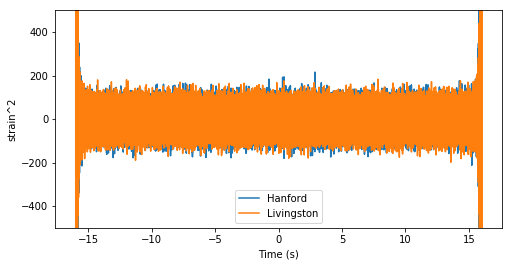

In [10]:
# Next, make a plot of the whitened data.
plt.figure(figsize=(8, 4))
plt.plot(time,invhan, label='Hanford')
plt.plot(time1,invliv, label='Livingston')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('strain^2')
plt.ylim(-500,500)

Now that we have cleaned up the data considerably, let's make a periodogram, using [`plt.specgram`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html). This plot shows the power spectrum as a function of time. It is constructed by cutting the data up into time slices and calculating the power spectrum of each slice (very similar to the function we used for the smoothed power spectrum). However, for this case we will use finer slices of data, so we have better time resolution, but we will allow the slices to overlap more heavily.


In [ ]:
# Define the list of frequencies

frequencies         = freqs

 

# Sampling Frequency

samplingFrequency   = sample_rate

 

# Create two ndarrays

s1 = freqs # For samples

s2 = invhan # For signal

 

# Start Value of the sample

start   = 1

 

# Stop Value of the sample

stop    = samplingFrequency+1

 

for frequency in frequencies:

    sub1 = np.arange(start, stop, 1)

 

    # Signal - Sine wave with varying frequency + Noise

    sub2 = np.sin(2*np.pi*sub1*frequency*1/samplingFrequency)+np.random.randn(len(sub1))

  

    s1      = np.append(s1, sub1)

    s2      = np.append(s2, sub2)

   

    start   = stop+1

    stop    = start+samplingFrequency

 

# Plot the signal

plt.subplot(211)

plt.plot(s1,s2)

plt.xlabel('Sample')

plt.ylabel('Amplitude')

 

 

# Plot the spectrogram

plt.subplot(212)

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(s2, Fs=samplingFrequency)

plt.xlabel('Time')

plt.ylabel('Frequency')

 

plt.show()   

In [ ]:
##### Add the variable name for your whitened time-ordered data here!!
data = invhan


# Spectrogram parameters

Nfft = int(sample_rate / 32.0) # Slice data into 1/32 of a second intervals.
Nover = int(Nfft * 15 / 16)
window = np.blackman(Nfft)
Fs = sample_rate

#define 2 d array, number of time slices by the number of points in fft. Figure out size, depends on how big time slices are and how they overlap. 
#go through and populate it by calculating more power spectra.

# Calculate the spectrogram
plt.figure(figsize=(10, 7))
(sgram, freqs, times, im) = plt.specgram(data, NFFT=Nfft, noverlap=Nover, window=window, Fs=Fs, 
                                         xextent=[time[0], time[-1]], vmin=0, vmax=10, scale='linear')
plt.xlabel('time [seconds]')
plt.ylabel('frequency [Hz]')
plt.colorbar()

# Can you see a feature near time = 0 seconds?
# Try zooming in on that region using the plt.xlim and plt.ylim functions.
#   plt.xlim(x1, x2) sets the x-axis range to run from x1 to x2
#   plt.ylim(y1, y2) sets the y-axis range to run from y1 to y2

plt.xlim(.25,.46)
plt.ylim(0,350)


In [ ]:
# Add the variable name for your whitened time-ordered data here!!
data1 = invliv
#data = fourierPHan
#data = divhan

# Spectrogram parameters

Nfft1 = int(sample_rate / 32.0) # Slice data into 1/32 of a second intervals.
Nover1 = int(Nfft1 * 15 / 16)
window1 = np.blackman(Nfft1)
Fs = sample_rate


# Calculate the spectrogram
plt.figure(figsize=(10, 7))
(sgram, freqs, times, im) = plt.specgram(data1, NFFT=Nfft1, noverlap=Nover1, window=window1, Fs=Fs, 
                                         xextent=[time[0], time[-1]], vmin=0, vmax=10, scale='linear')
plt.xlabel('time [seconds]')
plt.ylabel('frequency [Hz]')
plt.colorbar()
plt.xlim(.25,.46)
plt.ylim(0,350)




Can you identify the chirp signal of the binary black hole merger? 

If you have reached this point, then congratulations on your successful Fourier analysis! For bonus fun, return to the block of code where you whitened the data. There, you divided the Fourier transform of the data by the square root of the average noise power spectrum. But there are lots of other filter operations that you could apply. Try constructing a low-pass filter, *i.e.* a filter that only allows signals below some cut-off frequency, or a high-pass filter. Can you see the effect of these filters on your periodogram?
